In [ ]:
# Fist install the library

#%pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import numpy as np

from sklearn.metrics import accuracy_score
from keras import utils

from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import display_diff, add_noise
from rapidae.models.ae.ae_model import AE
from rapidae.models.base.default_architectures import VanillaEncoder, VanillaDecoder
from rapidae.pipelines.training import TrainingPipeline

2023-12-22 01:00:55.989994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 01:00:55.990023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 01:00:55.990887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 01:00:55.996696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 01:00:56.827528: W tensorflow/compiler/tf2

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

In [3]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Obtain the number number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-22 01:01:00 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-22 01:01:00 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-22 01:01:00 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-22 01:01:00 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


Since we want to train a denoising autoencoder, we also need to add some noise to the images.
The noise factor should be a float between 0 and 1 depending the intensity of the noise.

The used autoencoder to denoise the images is vanilla without convolutional layers so we need to flatten the images before we use it as inputs.

In [8]:
# Add noise to the train and test data
x_train_noisy = add_noise(x_train, noise_factor=0.4)
x_test_noisy = add_noise(x_test, noise_factor=0.4)

# Flatten data
x_train = x_train.reshape(x_train.shape[0], -1)
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape[0], -1)

print(x_train.shape)
print(x_train_noisy.shape)

(60000, 784)
(60000, 784)


Since the denoising autoencoder in structure is a vanilla autoencoder (only its functionality varies), the encoder and decoder are the vanilla ones, depth of the network and number of neurons per layer can be defined by using the layers_conf parameter.
The latent_dim determinates the dimensionality of the latent space.

In [5]:
# Model creation
model = AE(input_dim=x_train_noisy.shape[1], latent_dim=10,
           encoder=VanillaEncoder, decoder=VanillaDecoder, layers_conf=[64, 32])

Define the training pipeline. There you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc.
Here you can define callbacks to the model.
Also the pipeline's name can be customized to facilitate the identification of the corresponding folder with the saved models inside output_dir folder.

In [9]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=50)

trained_model = pipe(x=x_train_noisy, y=x_train)

2023-12-22 01:05:28 [INFO]: +++ training_pipeline +++
2023-12-22 01:05:28 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-22_01-05-28


Epoch 1/50

Epoch 1: loss improved from inf to 0.09938, saving model to ../output_dir/training_pipeline_2023-12-22_01-05-28/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0994
Epoch 2/50

Epoch 2: loss improved from 0.09938 to 0.08147, saving model to ../output_dir/training_pipeline_2023-12-22_01-05-28/model.weights.h5
469/469 - 1s - 3ms/step - loss: 0.0815
Epoch 3/50

Epoch 3: loss improved from 0.08147 to 0.07930, saving model to ../output_dir/training_pipeline_2023-12-22_01-05-28/model.weights.h5
469/469 - 1s - 3ms/step - loss: 0.0793
Epoch 4/50

Epoch 4: loss improved from 0.07930 to 0.07800, saving model to ../output_dir/training_pipeline_2023-12-22_01-05-28/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0780
Epoch 5/50

Epoch 5: loss improved from 0.07800 to 0.07705, saving model to ../output_dir/training_pipeline_2023-12-22_01-05-28/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0770
Epoch 6/50

Epoch 6: loss improved from 0.07705 to 0.07631, saving model to ../outpu

Evaluation phase using test data

In [10]:
y_hat = trained_model.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Finally the original images with noise can be graphically compared with the output images of the autoencoder.
As you can see, the added noise of the input images has largely disappeared.

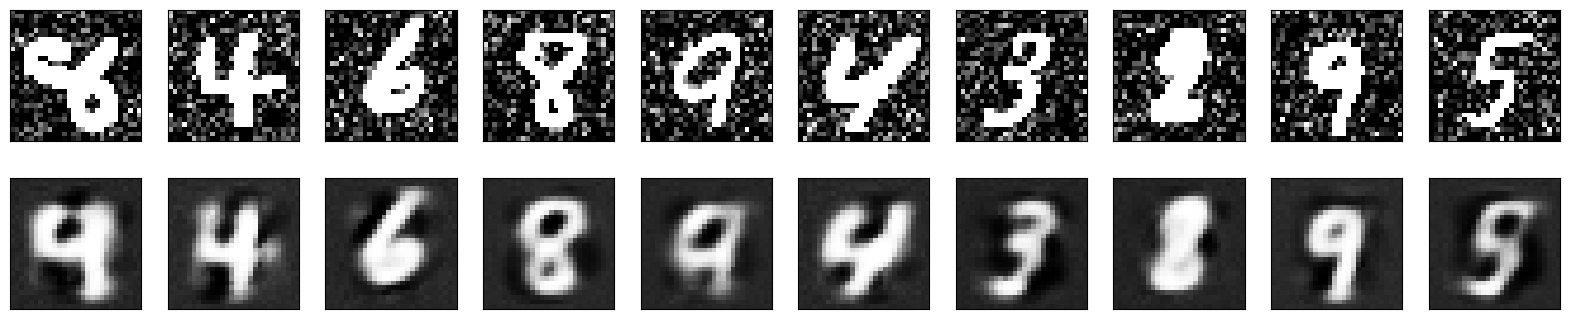

In [11]:
display_diff(x_test_noisy, y_hat['recon'])